## OPE in Reinforcement Learning

The second problem is concerned with OPE under the CartPole environment. We aim to estimate the value of a certain policy based on data generated by another policy. 

In [1]:
import gym  
from sklearn.neural_network import MLPRegressor
import sklearn.exceptions
import numpy as np
import warnings
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
warnings.simplefilter("ignore", category=sklearn.exceptions.ConvergenceWarning)

In [2]:
env = gym.make("CartPole-v1")  

episodes_for_behavior_policy = 100
num_mc_episodes_for_target_policy = 10000
regression_iterations = 60 
gammas = np.array([0.95, 0.99, 1])
lr = 0.5
tol = 1e-4

The behavior policy is chosen to be the same as in HW7, that is we choose a parameter $\epsilon$ for which we randomly pick an action. With probability $1 - \varepsilon$ we pick our action based on the angle of the pole.

In [3]:
def behavior_policy(angle, epsilon=0):
    if np.random.binomial(1, epsilon) == 1:
        return np.random.choice([0,1])
    else:
        if angle < 0:
            return 0
        else:
            return 1

As for the target policy, we can consider a fixed policy that push the cart to the left when the angle is negative and push the cart to the right when the angle is positive. So it is the same as the behavior policy with $\varepsilon = 0$. 

In [4]:
def target_policy(angle):
    return behavior_policy(angle)

We first use the Monte Carlo method to evaluate the true value under this policy for $\gamma = 0.95, 0.99, 1.00$. 

In [5]:
rewards = np.zeros((gammas.shape[0], num_mc_episodes_for_target_policy))

for i in tqdm(range(num_mc_episodes_for_target_policy)):
    obs = env.reset()
    obs = obs[0]
    done = False
    reward = np.zeros_like(gammas)
    gam_pow = np.ones_like(gammas)
    while not done:
        a = target_policy(obs[2])
        obs, r, done, info, _ = env.step(a)
        reward += gam_pow * r 
        gam_pow *= gammas
    rewards[:,i] = reward

mc_rewards_target_policy = np.mean(np.array(rewards), axis=1) 

print(f"Monte Carlo reward of target policy is {mc_rewards_target_policy}")

  0%|          | 0/10000 [00:00<?, ?it/s]

Monte Carlo reward of target policy is [17.44633696 34.21167484 42.0513    ]


Next, we generate data with the behavior policy.

In [6]:
sar = []
sar_by_episode = []
initial_states = []

for i in tqdm(range(episodes_for_behavior_policy)):
    obs = env.reset()
    obs = obs[0]
    done = False
    initial = True
    cur_sar = []
    while not done:
        a = behavior_policy(obs[2], epsilon=0.5)
        obs, r, done, info, _ = env.step(a)
        if initial:
            initial_states.append(obs)
            initial = False
        cur_sar.append([obs, a, r, done])
    sar_by_episode.append(cur_sar)

sar = [item for cur_sar in sar_by_episode for item in cur_sar] 

  0%|          | 0/100 [00:00<?, ?it/s]

# Stepwise IS Estimator

As a first step we aim to estimate the value of the target policy using the Stepwise IS Estimator. Recall from the lecture that it has large variance. This can be clearly variried by noting that if for some episode there is a time step $j$ such that $\pi(A_j | S_j) = 0$, then for all $t \ge j$ we have

$$\prod_{i = 0}^t\frac{\pi(A_i | S_i)}{\hat b(A_i | S_i)} = 0.$$

<img src="graphs/stepwise_is_estimator.png" width=800>

First, we define the estimated behaviour as below. The estimated behavior returns the values $b(A_i | S_i)$.

In [7]:
def estimated_behaviour(angle, action, epsilon=0.5):
    return epsilon * 0.5 + (1-epsilon) * (action == (angle >= 0)) 

We can now computee the Stepwise IS Estimators for $\gamma = 0.95, 0.99, 1.00$.

In [8]:
step_wise_estimator = np.zeros_like(gammas)
for cur_sar in sar_by_episode:
    cur_gamma = np.ones_like(gammas)
    cur_prod = 1.
    for t in range(len(cur_sar)):
        obs, action, _, _ = cur_sar[t]
        target_action = target_policy(obs[2])
        pi_a_s = target_action == action
        b_a_s = estimated_behaviour(obs[2], action)
        cur_prod *=  pi_a_s/ b_a_s 
        step_wise_estimator += cur_gamma * cur_prod
        cur_gamma *= gammas
step_wise_estimator /= len(sar_by_episode)
print(f"Step wise estimator gives for gamme values {gammas} the estimates {step_wise_estimator}")
print(f"Monte Carlo reward of target policy for gamme values {gammas} is {mc_rewards_target_policy}")

Step wise estimator gives for gamme values [0.95 0.99 1.  ] the estimates [4.47108301 4.91295436 5.0320378 ]
Monte Carlo reward of target policy for gamme values [0.95 0.99 1.  ] is [17.44633696 34.21167484 42.0513    ]


## Fitted Q Evaluation with MLPRegressor

Next, we employ the fitted-Q evaluation algorithm which iteratively updates the Q-function using the following formula
 \begin{eqnarray*}
 	\widehat{Q}_k=\mathrm{argmin}_{Q} \sum_{t} [R_{i,t}+\gamma \sum_{a} \pi(a|S_{i,t+1})\widehat{Q}_{k-1}(a,S_{i,t+1}) -Q(S_{i,t},A_{i,t})]^2.
 \end{eqnarray*}
Here, $i$ indexes the episode and $t$ indexes the decision time. In the CartPole example, similarly, when $S_{i,t}$ is a termination state, then the target becomes $R_{i,t}$. We use the MLPregressor to implement solve the regression problem. 
Given the Q-estimator, the value estimator is computed by the averaged value of $T^{-1}\sum_i \sum_a \pi(a|S_{i,t})\widehat{Q}_k(a,S_{i,0})$. 

In [9]:
## Intialize Q-function to be zero and construct target

X = np.zeros((len(sar), len(obs)+1))
y = np.zeros(len(sar))
for i in range(len(sar)):
    X[i,-1] = sar[i][1]
    X[i,0:len(obs)] = sar[i][0]

### Run Fitted-Q-Iteration

stored_estimates = np.zeros((len(gammas), regression_iterations))

for gamma_idx in tqdm(range(len(gammas))):
    gamma = gammas[gamma_idx]
    for i in range(len(sar)):
        y[i] = sar[i][2]
    regr0 = MLPRegressor(random_state=1, max_iter=500, learning_rate_init=lr, tol=tol).fit(X[X[:,-1]==0,0:-1], y[X[:,-1]==0])
    regr1 = MLPRegressor(random_state=1, max_iter=500, learning_rate_init=lr, tol=tol).fit(X[X[:,-1]==1,0:-1], y[X[:,-1]==1])
    for k in tqdm(range(regression_iterations)):
        for i in range(len(sar)):
            if sar[i][3]:
                y[i] = sar[i][2]
            else:
                action = target_policy(sar[i+1][0][2])
                y[i] = sar[i][2] + gamma * ((1-action) * regr0.predict(np.expand_dims(sar[i+1][0], 0)) + action * regr1.predict(np.expand_dims(sar[i+1][0], 0)))
        regr0 = MLPRegressor(random_state=1, max_iter=500, learning_rate_init=0.2).fit(X[X[:,-1]==0,0:-1], y[X[:,-1]==0])
        regr1 = MLPRegressor(random_state=1, max_iter=500, learning_rate_init=0.2).fit(X[X[:,-1]==1,0:-1], y[X[:,-1]==1])

        ### Run Estimator on initial states

        regr = [regr0, regr1]

        estimated_value = 0
        for state in initial_states:
            target_action = target_policy(state[2])
            estimated_value += regr[target_action].predict(np.expand_dims(state, axis=0))
        estimated_value /= len(initial_states)
        # tqdm.write(f"Estimated value after {k} iterations for gamma {gamma} is {estimated_value}")
        stored_estimates[gamma_idx, k] = estimated_value

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Finally, we plot the results

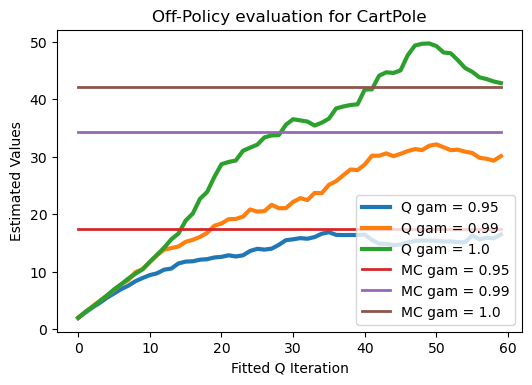

In [10]:
plt.figure(figsize=(6, 4), dpi=100)
plt.title("Off-Policy evaluation for CartPole")

for idx, gamma in enumerate(gammas):
    plt.plot(range(regression_iterations), stored_estimates[idx], label=f"Q gam = {gamma}",linewidth=3)

for idx, gamma in enumerate(gammas):
    mc_val = np.full((regression_iterations), mc_rewards_target_policy[idx])
    plt.plot(range(regression_iterations), mc_val, label = f"MC gam = {gamma}", linewidth=2)

plt.xlabel("Fitted Q Iteration")
plt.ylabel("Estimated Values")

plt.legend()

plt.show()